# Notebook para analisar os dados da base Bolsa Família

## Importando as bibliotecas necessárias

In [93]:
# Importando a sessão do Spark que se comunica com o cluster
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, TimestampType, StringType, DoubleType
from pyspark.sql.functions import regexp_replace, col, to_timestamp, expr, when

## Iniciando Sessão Spark e importando o arquivo CSV

In [17]:
#Instanciando a sessão spark
spark = SparkSession.builder.appName("Bolsa Familia").getOrCreate()

In [55]:
caminho = "./data/202401_NovoBolsaFamilia.csv"

df = spark.read.csv(path=caminho, 
                    header=True,
                    sep=';',
                    encoding='ISO-8859-1')

df.show()

+---------------+--------------+---+----------------------+--------------------+--------------+--------------+--------------------+-------------+
|MÊS COMPETÊNCIA|MÊS REFERÊNCIA| UF|CÓDIGO MUNICÍPIO SIAFI|      NOME MUNICÍPIO|CPF FAVORECIDO|NIS FAVORECIDO|     NOME FAVORECIDO|VALOR PARCELA|
+---------------+--------------+---+----------------------+--------------------+--------------+--------------+--------------------+-------------+
|         202401|        202303| AC|                  0139|          RIO BRANCO|***.511.972-**|   16291115205|JANAINA FERREIRA ...|       800,00|
|         202401|        202303| BA|                  3329|             ANGUERA|***.909.745-**|   20474429886|TACIANE MARQUES D...|       750,00|
|         202401|        202303| BA|                  3731|         MONTE SANTO|***.872.338-**|   20195376298|MAILSON DOS SANTO...|       650,00|
|         202401|        202303| BA|                  3761|         NOVA VICOSA|***.665.905-**|   12723589082|IRENI RICARDO 

## Ajustando os tipos dos dados

In [56]:
df.printSchema()

root
 |-- MÊS COMPETÊNCIA: string (nullable = true)
 |-- MÊS REFERÊNCIA: string (nullable = true)
 |-- UF: string (nullable = true)
 |-- CÓDIGO MUNICÍPIO SIAFI: string (nullable = true)
 |-- NOME MUNICÍPIO: string (nullable = true)
 |-- CPF FAVORECIDO: string (nullable = true)
 |-- NIS FAVORECIDO: string (nullable = true)
 |-- NOME FAVORECIDO: string (nullable = true)
 |-- VALOR PARCELA: string (nullable = true)



In [77]:
df_cast = df.withColumn(
    'MÊS COMPETÊNCIA', to_timestamp('MÊS COMPETÊNCIA', 'yyyyMM')
).withColumn(
    'MÊS REFERÊNCIA', to_timestamp('MÊS REFERÊNCIA', 'yyyyMM')
).withColumn(
    'NIS FAVORECIDO', col('NIS FAVORECIDO').cast('long')
).withColumn(
    'VALOR PARCELA', regexp_replace('VALOR PARCELA', ',', '.')
).withColumn(
    'VALOR PARCELA', col('VALOR PARCELA').cast('double')
)

In [78]:
df_cast.printSchema()

root
 |-- MÊS COMPETÊNCIA: timestamp (nullable = true)
 |-- MÊS REFERÊNCIA: timestamp (nullable = true)
 |-- UF: string (nullable = true)
 |-- CÓDIGO MUNICÍPIO SIAFI: string (nullable = true)
 |-- NOME MUNICÍPIO: string (nullable = true)
 |-- CPF FAVORECIDO: string (nullable = true)
 |-- NIS FAVORECIDO: long (nullable = true)
 |-- NOME FAVORECIDO: string (nullable = true)
 |-- VALOR PARCELA: double (nullable = true)



In [79]:
df_cast.show()

+-------------------+-------------------+---+----------------------+--------------------+--------------+--------------+--------------------+-------------+
|    MÊS COMPETÊNCIA|     MÊS REFERÊNCIA| UF|CÓDIGO MUNICÍPIO SIAFI|      NOME MUNICÍPIO|CPF FAVORECIDO|NIS FAVORECIDO|     NOME FAVORECIDO|VALOR PARCELA|
+-------------------+-------------------+---+----------------------+--------------------+--------------+--------------+--------------------+-------------+
|2024-01-01 00:00:00|2023-03-01 00:00:00| AC|                  0139|          RIO BRANCO|***.511.972-**|   16291115205|JANAINA FERREIRA ...|        800.0|
|2024-01-01 00:00:00|2023-03-01 00:00:00| BA|                  3329|             ANGUERA|***.909.745-**|   20474429886|TACIANE MARQUES D...|        750.0|
|2024-01-01 00:00:00|2023-03-01 00:00:00| BA|                  3731|         MONTE SANTO|***.872.338-**|   20195376298|MAILSON DOS SANTO...|        650.0|
|2024-01-01 00:00:00|2023-03-01 00:00:00| BA|                  3761|  

In [84]:
df_cast = df_cast.withColumnRenamed(
    'MÊS COMPETÊNCIA', 'mes_comp'
).withColumnRenamed(
    'MÊS REFERÊNCIA', 'mes_ref'
).withColumnRenamed(
    'CÓDIGO MUNICÍPIO SIAFI', 'cod_mun'
).withColumnRenamed(
    'NOME MUNICÍPIO', 'nome_mun'
).withColumnRenamed(
    'CPF FAVORECIDO', 'cpf'
).withColumnRenamed(
    'NIS FAVORECIDO', 'nis'
).withColumnRenamed(
    'NOME FAVORECIDO', 'nome_fav'
).withColumnRenamed(
    'VALOR PARCELA', 'valor'
)

df_cast.show()

+-------------------+-------------------+---+-------+--------------------+--------------+-----------+--------------------+------+
|           mes_comp|            mes_ref| UF|cod_mun|            nome_mun|           cpf|        nis|            nome_fav| valor|
+-------------------+-------------------+---+-------+--------------------+--------------+-----------+--------------------+------+
|2024-01-01 00:00:00|2023-03-01 00:00:00| AC|   0139|          RIO BRANCO|***.511.972-**|16291115205|JANAINA FERREIRA ...| 800.0|
|2024-01-01 00:00:00|2023-03-01 00:00:00| BA|   3329|             ANGUERA|***.909.745-**|20474429886|TACIANE MARQUES D...| 750.0|
|2024-01-01 00:00:00|2023-03-01 00:00:00| BA|   3731|         MONTE SANTO|***.872.338-**|20195376298|MAILSON DOS SANTO...| 650.0|
|2024-01-01 00:00:00|2023-03-01 00:00:00| BA|   3761|         NOVA VICOSA|***.665.905-**|12723589082|IRENI RICARDO GER...| 650.0|
|2024-01-01 00:00:00|2023-03-01 00:00:00| BA|   3849|            SALVADOR|***.932.435-**|2

In [92]:
# Filtrar linhas com valores nulos em qualquer coluna
null_expr = ' OR '.join(f'{c} IS NULL' for c in df_cast.columns)
df_null = df_cast.filter(expr(null_expr))

# Exibir as linhas nulas
df_null.show()

+-------------------+-------------------+---+-------+---------------+----+-----------+--------------------+-----+
|           mes_comp|            mes_ref| UF|cod_mun|       nome_mun| cpf|        nis|            nome_fav|valor|
+-------------------+-------------------+---+-------+---------------+----+-----------+--------------------+-----+
|2024-01-01 00:00:00|2023-04-01 00:00:00| AM|   0255|         MANAUS|NULL|12463573564|FATIMA APARECIDA ...|600.0|
|2024-01-01 00:00:00|2023-04-01 00:00:00| MA|   0741|         BURITI|NULL|16571831458|NIVEA MAKENNA DA ...|750.0|
|2024-01-01 00:00:00|2023-04-01 00:00:00| RJ|   5909|      SAQUAREMA|NULL|12866937874|MARIA HUMBERLANDI...|750.0|
|2024-01-01 00:00:00|2023-04-01 00:00:00| SP|   6953|       REGISTRO|NULL|12658426250|APARECIDA DO ROSA...|600.0|
|2024-01-01 00:00:00|2023-05-01 00:00:00| AM|   0255|         MANAUS|NULL|12463573564|FATIMA APARECIDA ...|600.0|
|2024-01-01 00:00:00|2023-05-01 00:00:00| MA|   0741|         BURITI|NULL|16571831458|NI

Aparentemente algumas linhas não possuem o CPF, porém possuem o número do NIS

https://www.caixa.gov.br/programas-sociais/bolsa-familia/Paginas/default.aspx

Famílias com renda menor ou igual a 218,00 por pessoa

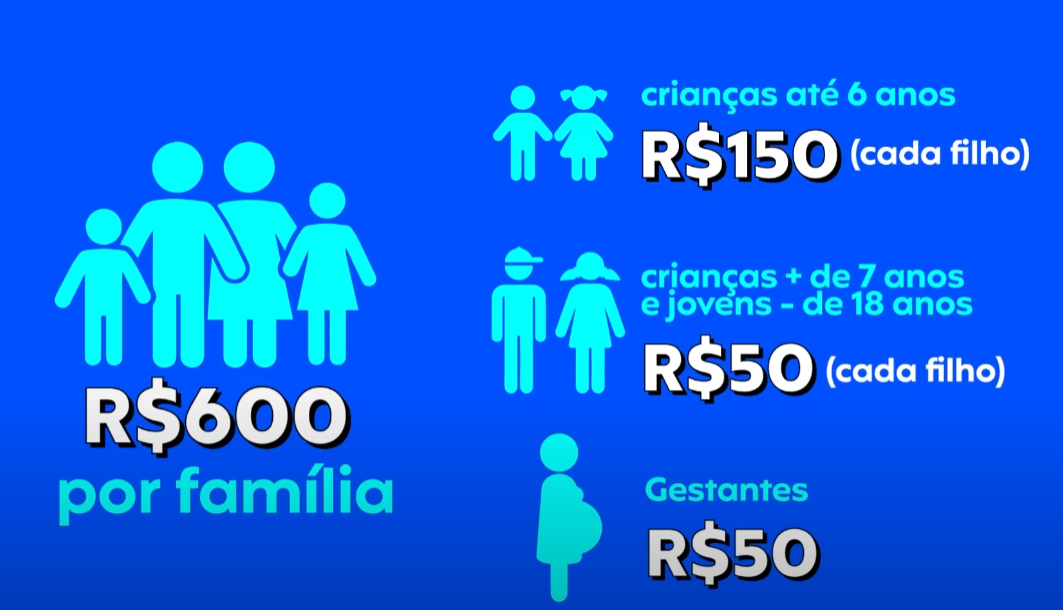

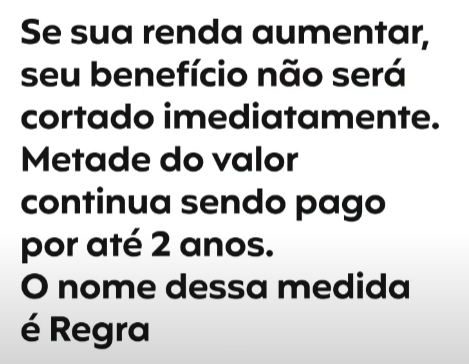